In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from pysindy.differentiation import FiniteDifference
import Yukawa_SINDy as ys
import cross_validation as cv
from sklearn.metrics import root_mean_squared_error
from importlib import reload

In [3]:
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

# Model validation check

This notebook will be used to look more deeply into the way that I am currently doing model validation in my cross-validation scheme. I will look at both weak and strong library examples and compare the RMSE values.

In [130]:
noise_level = 0.1
threshold = 0.94
feature_names = ['x','v']

sim_list = ys.generate_training_data(
    noise_level = noise_level,
    scaled=True
)

# pull out data for training and testing
x_test = [sim.x for sim in sim_list[150:]]
x_train = [sim.x for sim in sim_list[:150]]
t = sim_list[0].t

## Strong library

In [131]:
# fit SINDy strong_model
optimizer = ps.STLSQ(threshold = threshold)
strong_library = ys.generate_Yukawa_library() # generate strong library
strong_model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=strong_library, 
    feature_names=feature_names
)
strong_model.fit(x_train,t, multiple_trajectories=True)
# predict with SINDy method and straight from coefficients
x_dot_predicted_SINDy_method = strong_model.predict(x_test,multiple_trajectories=True)

coefficients = strong_model.coefficients()
fitted_library = strong_library.transform(x_test)
x_dot_predicted_manual = fitted_library @ coefficients.T

# predict with finite difference
fd = FiniteDifference()
x_dot_calculated = fd._differentiate(x_test[0], t)


/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.94) and eliminated all coefficients
  warnings.warn(


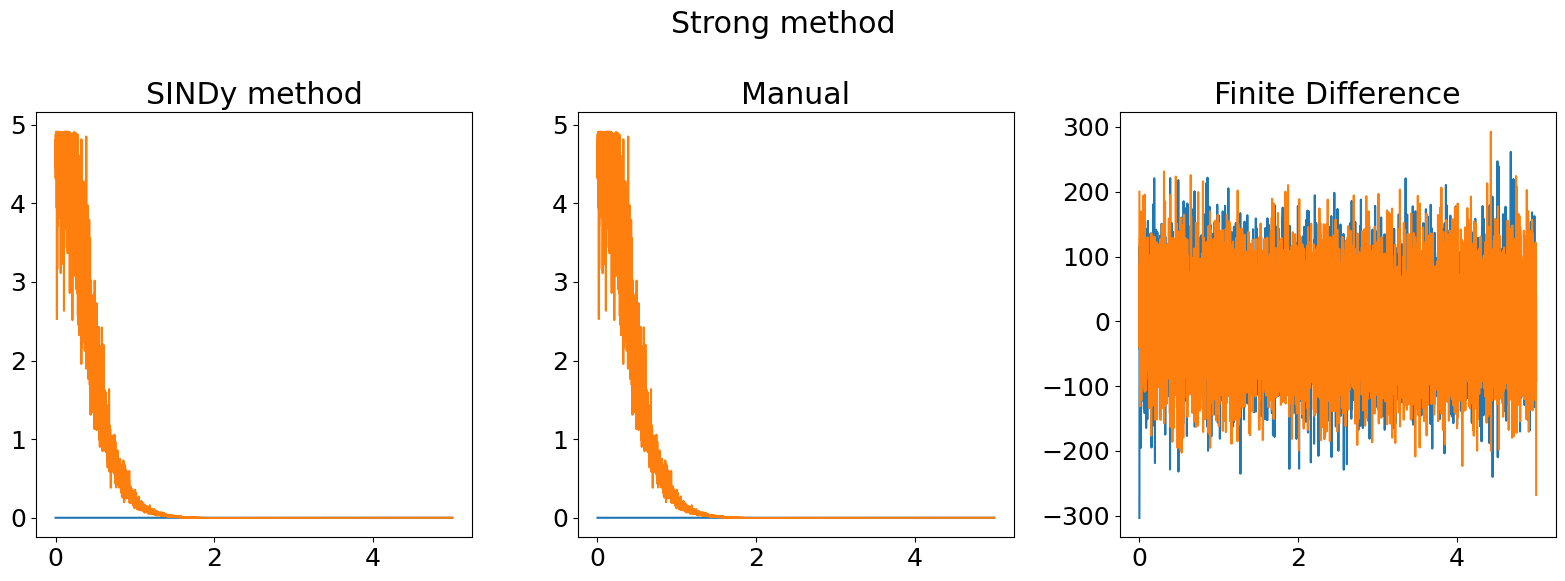

In [132]:
fig, axs = plt.subplots(1,3,figsize=(16,6))
titles = ["SINDy method", "Manual", "Finite Difference"]
data = [
    x_dot_predicted_SINDy_method[0],
    x_dot_predicted_manual[0],
    x_dot_calculated
]
for i, ax in enumerate(axs):
    ax.plot(t, data[i])
    ax.set_title(titles[i])
fig.suptitle("Strong method")
fig.tight_layout()

The finite difference method with noisy data gives a really unrealistic error value since the noise on the training data is *so* inflated by this numerical approach. For this project, it is perhaps a better idea to use the "true" trajectory for model validation/selection, but the only problem is that this does not apply to research applications.

### Calculating the RMSE values

In [133]:
strong_model.coefficients()

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , -10.82761331,   0.        ,
         52.93292537,   0.        , -39.24419695,   0.        ,
          7.50734498,   0.        ]])

In [134]:
strong_model.score(x_test, t, multiple_trajectories=True, metric=root_mean_squared_error)

71.28779878100501

In [135]:
root_mean_squared_error(x_dot_predicted_SINDy_method[0], x_dot_calculated)

71.29073782104106

Slightly different since the manual method is only on one trajectory.

In [9]:
root_mean_squared_error(x_dot_predicted_manual[0], x_dot_calculated)

71.27793526649636

## Weak library

In [147]:
# np.random.seed(192847)
# fit weak SINDy model
optimizer = ps.STLSQ(threshold = threshold)
weak_library = ys.generate_weak_Yukawa_library(t) # generate strong library
weak_model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=weak_library, 
    feature_names=feature_names
)
weak_model.fit(x_train,t, multiple_trajectories=True)
# predict with SINDy method and straight from coefficients
x_dot_predicted_SINDy_method = weak_model.predict(x_test,multiple_trajectories=True)

coefficients = weak_model.coefficients()
fitted_library = weak_library.transform(x_test) # use strong library to generate fitted library because weak_library.transform is wrong size
x_dot_predicted_manual = fitted_library @ coefficients.T

# predict with finite difference
fd = FiniteDifference()
x_dot_calculated = fd._differentiate(x_test[0], t)
weak_model.coefficients()

array([[0.        , 1.00100094, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 4.61653177, 0.        , 3.73067483,
        0.        , 0.3650058 , 0.        , 0.        , 0.        ]])

In [148]:
weak_model.score(x_test,t,multiple_trajectories=True,metric=root_mean_squared_error)

0.0143489297280594

In [67]:
x_dot_predicted_SINDy_method_weak = weak_model.predict(x_test, multiple_trajectories=True)
x_dot_predicted_SINDy_method_weak[0].shape

(100, 2)

ValueError: x and y must have same first dimension, but have shapes (5000,) and (100, 2)

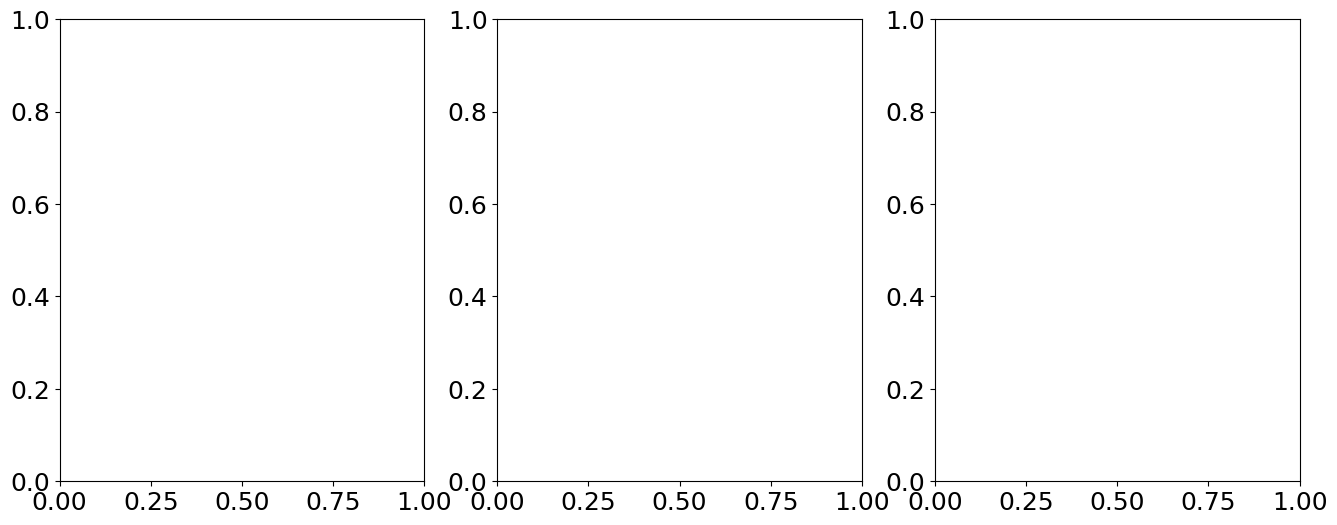

In [12]:
fig, axs = plt.subplots(1,3,figsize=(16,6))
titles = ["SINDy method", "Manual", "Finite Difference"]
data = [
    x_dot_predicted_SINDy_method[0],
    x_dot_predicted_manual[0],
    x_dot_calculated
]
for i, ax in enumerate(axs):
    ax.plot(t, data[i])
    ax.set_title(titles[i])
fig.suptitle("Weak method")
fig.tight_layout()